# Исследовательский анализ данных

# Обработка фотографий покупателя

### Описание проекта

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы и контролировать добросовестность кассиров при продаже алкоголя. Необходимо построить модель, которая по фотографии определит приблизительный возраст человека.

### План проекта

    1. Исследовательский анализ набора фотографий
    2. Обучение нейронной сети
    3. Выводы

### Описание данных

Для аналза предоставлен набор фотографий людей с указанием возраста. В распоряжении одна папка со всеми изображениями и CSV-файл с двумя колонками: file_name и real_age.

## 1. Исследовательский анализ набора фотографий

In [1]:
# импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Conv2D, Flatten, AvgPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# функция для загрузки данных
def load_data(path):
    datagen = ImageDataGenerator(rescale=1./255)
    datagen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path+'/labels.csv'),
        directory=path+'/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)
    return datagen_flow

In [3]:
# загрузка данных
gen_flow = load_data('/datasets/faces')

Found 7591 validated image filenames.


In [4]:
# определение размера выборки
labels = pd.read_csv('/datasets/faces/labels.csv')
print(labels.shape[0])

7591


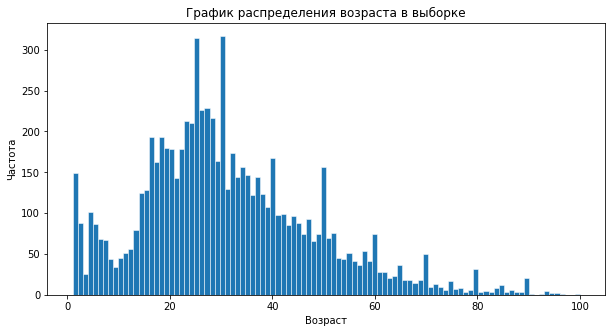

In [17]:
# график распределения возраста в выборке
fig, ax = plt.subplots(figsize=(10,5))
ax.hist(labels['real_age'], bins=100, linewidth=0.5, edgecolor="white")
ax.set(title='График распределения возраста в выборке', xlabel='Возраст', \
      ylabel='Частота')
plt.show();

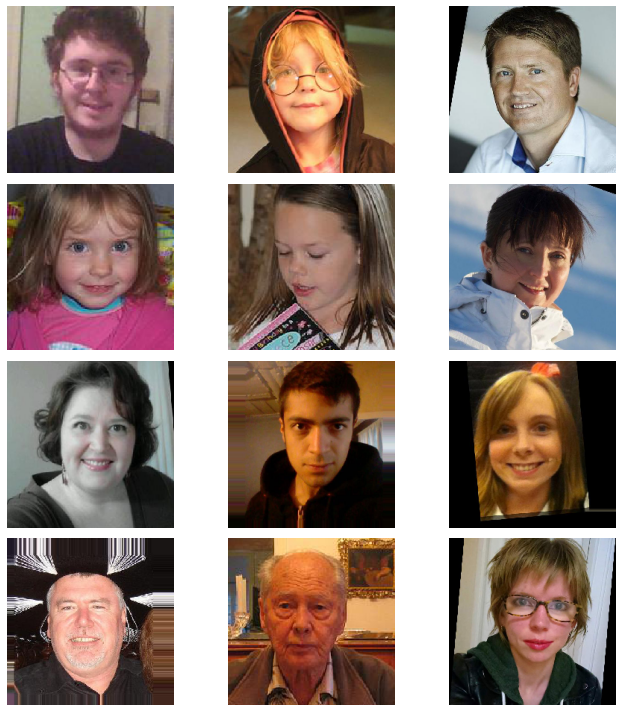

In [23]:
features, target = next(gen_flow)
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 3, i+1)
    plt.imshow(features[i])
    plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

    1) В выборке 7591 изображений
    2) Распределение возраста в выборке похоже на нормальное распределение
    3) Датасет содержит цветные и черно-белые изображения, а также изображения с поворотами 
***Вывод***: можно применять ResNet50 без заморозки

## 2. Обучение нейронной сети

Далее код обучения модели и её результат вывода на экран.(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import numpy as np
import pandas as pd
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# In[2]:


def load_train(path):
 train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255, horizontal_flip=True, vertical_flip=True)
 train_datagen_flow = train_datagen.flow_from_dataframe(
 dataframe=pd.read_csv(path+'/labels.csv'), 
 directory=path+'/final_files/', 
 x_col='file_name', 
 y_col='real_age', 
 target_size=(224, 224),
 batch_size=32,
 class_mode='raw',
 subset='training',
 seed=12345)
 return train_datagen_flow


# In[3]:


def load_test(path):
 test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
 test_datagen_flow = test_datagen.flow_from_dataframe(
 dataframe=pd.read_csv(path+'/labels.csv'), 
 directory=path+'/final_files/', 
 x_col='file_name',
 y_col='real_age',
 target_size=(224, 224),
 batch_size=32,
 class_mode='raw',
 subset='validation',
 seed=12345)
 return test_datagen_flow


# In[4]:


def create_model(input_shape):
 backbone = ResNet50(input_shape=input_shape, weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False)
 model = Sequential()
 model.add(backbone)
 model.add(GlobalAveragePooling2D())
 model.add(Dense(units=84, activation='relu'))
 model.add(Dense(units=12, activation='relu'))
 model.add(Dense(units=1, activation='relu'))
 optimizer = Adam(lr=0.0001)
 model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mae'])
 return model


# In[5]:


def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):
 if steps_per_epoch is None:
 steps_per_epoch = len(train_data)
 if validation_steps is None:
 validation_steps = len(test_data)
 model.fit(train_data, validation_data=test_data, batch_size=batch_size, epochs=epochs, \
 steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, verbose=2, shuffle=True)
 return model

```

```
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 48s - loss: 16.9328 - mae: 16.9359 - val_loss: 20.0094 - val_mae: 20.0020
Epoch 2/10
178/178 - 40s - loss: 8.3832 - mae: 8.3834 - val_loss: 19.5898 - val_mae: 19.5776
Epoch 3/10
178/178 - 40s - loss: 7.4037 - mae: 7.4040 - val_loss: 12.8896 - val_mae: 12.8587
Epoch 4/10
178/178 - 40s - loss: 6.8548 - mae: 6.8554 - val_loss: 10.0398 - val_mae: 10.0452
Epoch 5/10
178/178 - 40s - loss: 6.3802 - mae: 6.3809 - val_loss: 7.5993 - val_mae: 7.6208
Epoch 6/10
178/178 - 40s - loss: 6.0149 - mae: 6.0154 - val_loss: 7.2337 - val_mae: 7.2500
Epoch 7/10
178/178 - 40s - loss: 5.6072 - mae: 5.6078 - val_loss: 8.6221 - val_mae: 8.6544
Epoch 8/10
178/178 - 40s - loss: 5.2174 - mae: 5.2176 - val_loss: 7.0416 - val_mae: 7.0354
Epoch 9/10
178/178 - 40s - loss: 5.1269 - mae: 5.1274 - val_loss: 7.2268 - val_mae: 7.2340
Epoch 10/10
178/178 - 40s - loss: 4.9097 - mae: 4.9092 - val_loss: 6.7233 - val_mae: 6.7495
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 6.7233 - mae: 6.7495
Test MAE: 6.7495


```

## 3. Выводы

Достичь значения MAE = 6.7495 на тестовой выбрке получилось с помощью модели со следующими параметрами:
    
    1) использовалась RESNET50, предобученная на ImageNet
    2) для адаптации под задачу были использованы три полносвязных слоя с 84, 12 и 1 нейронами соответственно, и с функцией активации ReLu
    3) использовался алгоритм adam со скоростью обучения 0.0001 для автоматического подбора шага градинтного спуска